In [7]:
#import necessary libraries
from glob import glob
from osgeo import gdal
from skimage import exposure
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
# from rasterio.plot import plotting_extent
# from rasterio.plot import show
# from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import numpy as np
from skimage import filters
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import plotly.graph_objects as go
# from osgeo import gdal
from skimage.filters import median
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

**Before Flood**

In [ ]:
#accessing drive for data
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %cd /content/drive/My Drive/satellite_data

/content/drive/My Drive/satellite_data


In [8]:
# file reading
before_floods = glob("*s1a?*.tiff")
before_floods.sort()
before_floods

[]

In [15]:
# file reading using gdal
before_floods_gdalview = gdal.Open("test.tif")
#reading file using pillow
before_floods_pilview = np.array(Image.open("test.tif"))

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\dev\\Notebook\\Flood-Monitoring-and-Prediction-Using-Sentinel-1-SAR-Data\\test.tif'

In [6]:
# Get the metadata
metadata = before_floods_gdalview.GetMetadata()

In [7]:
# Read the image data as array
arr_before_floods = before_floods_gdalview.ReadAsArray()

In [8]:
#dB scaling
arr_before_floods = 10 * np.log10(arr_before_floods)

In [10]:
# Apply speckle filtering
filtered_bef = np.zeros_like(arr_before_floods)
for i in range(arr_before_floods.shape[0]):
    filtered_bef[i,:] = median(arr_before_floods[i,:])

In [14]:
# Normalise
min_value = np.min(filtered_bef)
max_value = np.max(filtered_bef)
norm_filtered_bef = (filtered_bef - min_value) / (max_value - min_value)

In [17]:
# Save the preprocessed image to a new tiff file
output_path = 'output/bef_output.tif'
driver = gdal.GetDriverByName('GTiff')
output_ds = driver.Create(output_path, before_floods_gdalview.RasterXSize, before_floods_gdalview.RasterYSize, before_floods_gdalview.RasterCount, gdal.GDT_Float32)
output_ds.SetGeoTransform(before_floods_gdalview.GetGeoTransform())
output_ds.SetProjection(before_floods_gdalview.GetProjection())

0

In [ ]:
#Flush the cache
for i in range(1, before_floods_gdalview.RasterCount + 1):
    band = output_ds.GetRasterBand(i)
    band.WriteArray(arr_before_floods[i-1,:,:])
    band.FlushCache()

Note: The above code consists of many experimental preprocessing steps. Yet preprocessing always varies with inputs and hence few of the above steps were not helpful with the current data. 

# Visualisation

In [7]:
list = []
for i in before_floods:
  with rio.open(i, 'r') as f:
    list.append(f.read(1))
arr_bef = np.stack(list)

In [ ]:
arr_bef.shape

(1, 16726, 25896)

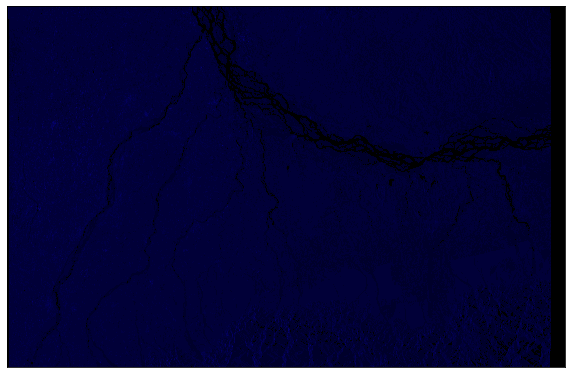

In [8]:
# Visalize Bands

ep.plot_bands(arr_bef, cmap='gist_earth', cols=3, figsize=(10, 10), cbar=False)   

plt.show()

# Grayscale Conversion
Grayscale conversion: Before utilising the flood monitoring technique, we first use the mean function in NumPy to convert the colour TIFF image to grayscale. The Otsu thresholding algorithm can only be used with grayscale images, which explains why.


In [10]:
gray = np.mean(before_floods_pilview, axis=1)

# Otsu Algorithm
The Otsu thresholding algorithm can be used to automatically choose a threshold value for separating a grayscale image's foreground from its background. This code computes the threshold value using the scikit-image threshold_otsu function, then uses NumPy's boolean comparison (>) to apply it to the grayscale image to produce a binary mask.

In [ ]:
thresh = filters.threshold_otsu(gray)
mask = gray > thresh

# Flood Coverage 
Flood coverage can be calculated by adding the elements of the binary mask that separate the flooded and unflooded areas and dividing the result by the total number of pixels in the image.


In [ ]:
coverage = np.sum(mask) / np.prod(mask.shape)

In [ ]:
print(f'Flood coverage: {coverage*100:.2f}%')

Flood coverage: 63.53%


**After Flood**

In [7]:
%cd /content/drive/My Drive/satellite_data/after

/content/drive/My Drive/satellite_data/after


In [4]:
# file reading
after_floods = glob("*s1a?*.tiff")
after_floods.sort()
after_floods

['s1a-iw-grd-vh-20220530t235534-20220530t235559-043447-053018-002.tiff',
 's1a-iw-grd-vv-20220530t235534-20220530t235559-043447-053018-001.tiff']

In [5]:
list2 = []
for i in after_floods:
  with rio.open(i, 'r') as f:
    list2.append(f.read(1))
    
arr_af = np.stack(list2)

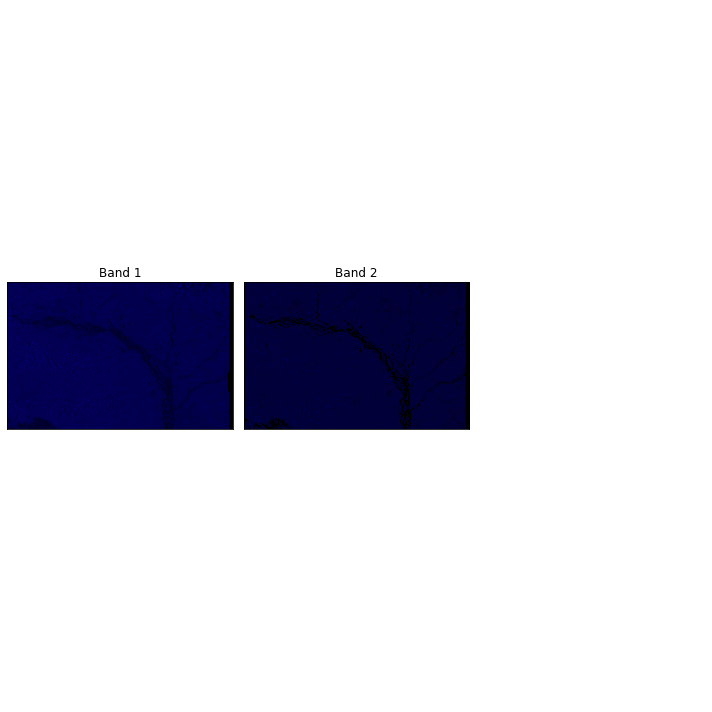

In [14]:
# Visalize Bands

ep.plot_bands(arr_af, cmap='gist_earth', cols=3, figsize=(10, 10), cbar=False)   

plt.show()

In [1]:
# ep.plot_rgb(arr_af, rgb=(), figsize=(10, 10))

# plt.show()
# The above code visualizes RGB Composite Image but can be heavy on the processor

In [8]:
#reading file using pillow
img_af1 = np.array(Image.open('s1a-iw-grd-vv-20220530t235534-20220530t235559-043447-053018-001.tiff'))
img_af2 = np.array(Image.open('s1a-iw-grd-vh-20220530t235534-20220530t235559-043447-053018-002.tiff'))

In [9]:
#Greyscal onversion
gray_af_1 = np.mean(img_af1, axis=1)
gray_af_2 = np.mean(img_af2, axis=1)

In [10]:
#otsu
thresh_af1 = filters.threshold_otsu(gray_af_1)
thresh_af2 = filters.threshold_otsu(gray_af_2)
mask_af1 = gray_af_1 > thresh_af1
mask_af2 = gray_af_2 > thresh_af2

In [11]:
#flood coverage calculation after floods
coverage_af1 = np.sum(mask_af1) / np.prod(mask_af1.shape)
coverage_af2 = np.sum(mask_af2) / np.prod(mask_af2.shape)

In [12]:
print(f'Flood coverage after: {coverage_af1*100:.2f}%')

Flood coverage after: 83.98%


In [13]:
print(f'Flood coverage after: {coverage_af2*100:.2f}%')

Flood coverage after: 80.46%


The overall area that has been impacted by the flood has been estimated in the above study. This has shown how much land has been inundated by floodwaters and gives us an idea of how much damage has been done to infrastructure, agriculture, and other assets.

The amount of land that has been submerged by flood waters on 04.05.2022 is **63.53%** whereas on 30.05.2022 is between **80.46 - 83.98%.**

#**Future Scope:**

Before conducting any operations on the sentinel data, preprocessing is necessary. The **advanced preprocessing measures** comprise the following:

1. Orbit File: The exact observations (taken by the Copernicus exact Orbit Determination (POD) Service) will be updated after about a week because the auxiliary spatial location (position) data linked with the image is not accurate (taken by GNSS). The sentinel products include accurate information that must be used before moving on to further processes.

2. Removal of Thermal Noise : Thermal noise is the noise that results from background energy produced by the SAR receiver and is present in the data. A look table is incorporated in the data products to rectify or eliminate the thermal noise.

3. Radiometric Calibration: Using the calibration coefficients found in the sentinel products, radiometric calibration converts DN values into radiance (radar backscatter of reflected surface).
In the SAR image, the speckle effect creates a granular look with random spatial fluctuations. Usually, it happens as a result of wave interference from various elements' reflected waves. Speckle filtering must be used to get rid of this effect.

4. Terrain Correction: Because SAR data are typically collected at wildly varying angles, there are geometric distortions. Terrain correction therefore seeks to reduce this distortion.

5. Subset: By specifying the geometry, subset is a straightforward method that extracts the area of interest from the entire sensor image.


The widely used software programme ESA SNAP (Sentinel Application Platform), which is used to handle and analyse satellite data, has a plugin called **Snappy**.

The Python library Snappy can be used as it offers users an easy-to-use interface for accessing and modifying satellite photography data. It contains a variety of reading, writing, and processing capabilities for data, including picture classification, spatial and spectral filtering, and data subsetting. Additionally, it enables users to plot and visualise the processed data using a variety of tools.

Various deep learning model trainings(UNET,LinkNet,etc) can be used in image segmentation in order to detect flooding on the images and further to predict flood impacts in th coming years.


Various other environmental data like rainfall, temperature, etc. can be inculcated in order to achieve improved analysis and forcasting results.

                                                          Thank you.
